In [146]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine # database connection
import sqlite3
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

from sklearn import datasets
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import scale
import datetime as dt
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Import Data

There are a few different dataframe that I will be using.

1. One that holds information on how people voted on bills.
2. One that has the ids for each elected official (i.e. it has the id the use for voting on bills, the id they use for contriubtions, etc.)
3. Multiple datasets that hold information on contributions.
    -This data is rather large and has trouble opening. To get around this I am going to create a database for contributiondata, and save each csv (2 year cycel) as its own table.
4. One that has category codes that reference contribution industries.

Here's where the dataset's can be found:
script to pull votes from api (warning, it needs to be refactored): 
https://github.com/alexhubbard89/DAT-NYC-30_alex_hubbard/blob/master/final_project/get_legislation_data_script.ipynb


contributions: http://sunlightlabs.github.io/datacommons/bulk_data.html
schema documentation, and id lists: http://sunlightlabs.github.io/datacommons/contribution.html

In [82]:
all_votes = pd.read_excel('/Users/Alexanderhubbard/Desktop/data_science/final_porject_data/all_bills/bill_votes_all.xlsx')

In [83]:
all_votes.head(2)

,bill_id,date,display_name,id,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra
0,hr2-101,1989-05-08,ANDERSON G,A000189,Democrat,CA,"[u'Agricultural labor', u'Alien labor', u'Amer...",Labor and employment,nay,NaN
1,hr2-101,1989-05-08,BARNARD DO,B000153,Democrat,GA,"[u'Agricultural labor', u'Alien labor', u'Amer...",Labor and employment,nay,NaN


In [78]:
all_ids = pd.read_csv('/Users/Alexanderhubbard/Desktop/data_science/final_porject_data/all_ids/legislators_all.csv')

In [79]:
all_ids.head(2)

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,thomas_id,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,11/9/52,M,sen,OH,NaN,Democrat,http://www.brown.senate.gov,713 Hart Senate Office Building Washington DC ...,...,136,N00003535,S307,5051,400050,27018,Sherrod Brown,gIQA3O2w9O,29389,Sherrod Brown
1,Cantwell,Maria,10/13/58,F,sen,WA,NaN,Democrat,http://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,...,172,N00007836,S275,26137,300018,27122,Maria Cantwell,gIQAZxKkDP,39310,Maria Cantwell


In [80]:
# This is only the id's I need
# I am shrinking this data to reduce expense
all_ids_subset = all_ids[['bioguide_id', 'opensecrets_id']]
all_ids_subset.head(2)

,bioguide_id,opensecrets_id
0,B000944,N00003535
1,C000127,N00007836


In [84]:
# osid stand for opensecrets_id. That is the id used
# to track campaign contributions
votes_with_osid = pd.merge(all_votes, all_ids_subset, left_on='id', right_on='bioguide_id')

# Not everyone has an opensecrets_id
# I'm dropping the officials who do not have one,
# as I need it in order to get their contribution history.
votes_with_osid = votes_with_osid.drop('id', 1)
votes_with_osid['opensecrets_id'] = votes_with_osid['opensecrets_id'].astype(str)
votes_with_osid.head(2)

,bill_id,date,display_name,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra,bioguide_id,opensecrets_id
0,hr2-101,1989-05-08,ANDERSON G,Democrat,CA,"[u'Agricultural labor', u'Alien labor', u'Amer...",Labor and employment,nay,NaN,A000189,nan
1,hr3-101,1990-04-24,Anderson,D,CA,NaN,Families,yea,NaN,A000189,nan


In [85]:
# I only care about officials that have an opensecret_id
# If they don't have it then I can't tell how much money raised.
# I'm getting rid of anyone without the opensecret_id.

votes_with_osid = votes_with_osid[votes_with_osid['opensecrets_id'] != 'nan'].reset_index(drop=True)
votes_with_osid.tail(2)

,bill_id,date,display_name,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra,bioguide_id,opensecrets_id
879592,hr320-112,2011-10-24,Barber,D,AZ,NaN,Public lands and natural resources,nay,NaN,B001279,N00033981
879593,hr3409-112,2012-09-21,Barber,D,AZ,NaN,Public lands and natural resources,nay,NaN,B001279,N00033981


In [118]:
# I am only looking at one bill subject:
# Armed Forces and National Security

afns_votes = votes_with_osid[votes_with_osid['subjects_top_terms'] ==
                             'Armed forces and national security'].reset_index(drop=True)
afns_votes.tail(2)

,bill_id,date,display_name,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra,bioguide_id,opensecrets_id
61834,hr3298-112,2012-03-27,Young (IN),R,IN,NaN,Armed forces and national security,yea,NaN,Y000064,N00030670
61835,hr3523-112,2012-04-26,Young (IN),R,IN,NaN,Armed forces and national security,yea,NaN,Y000064,N00030670


In [ ]:
# I am dropping any rows where someone voted for two bills for the same industry in one day
# my cleaning script does not account for that, and then the contribution section is off
afns_votes['datetete'] = pd.to_datetime(afns_votes['date'])
afns_votes = afns_votes.drop_duplicates(['date', 'opensecrets_id'])

# Make the database

Now I will make the database for contributions, and a function that will open each csv and save it as a table. Additionally, I am going to create a column to display which industry contributions are coming from. Originally the contribution data says which industry money is being collected from with a "Category Code." However, the problem is that each industry has multiple category codes (e.g. Lobbyist == K2000, K2100, etc.). I have a csv that has the category codes and lists which industry they are, so I will use that to find the industries for the category code. I will use a merge function to put this together (this is the same as the SQL join function).

In [12]:
# Initializes database with filename 311_8M.db in current directory
disk_engine = create_engine('sqlite:///contribution_data.db')

In [68]:
def add_data_to_db(year_x, append_or_replace):

    start = dt.datetime.now()
    chunksize = 20000
    j = 0
    index_start = 1
    db_name = str(year_x)+ '_contributions_db'
    data_to_import = "/Users/Alexanderhubbard/Desktop/data_science/final_porject_data/contributions/clean_contributions/contribution_clean.fec.{}.csv".format(year_x)
    columns = pd.read_csv(data_to_import, nrows=2).columns
    
    # The contribution data has the indsutry code numbers, but not
    # the name of the industyr. I'm going to use a csv that has the 
    # industry code number and the industry name, and join it with the
    # contribution data. This will be used to easily get contributions
    # by industry.
    industry_names = pd.read_csv('/Users/Alexanderhubbard/Desktop/data_science/final_porject_data/contributions/contribution_ids/catcodes.csv')
    industry_names = industry_names[['code','industry']]
    
    print "importing!"

    for df in pd.read_csv(data_to_import, error_bad_lines=False, chunksize=chunksize, iterator=True, encoding='cp1252'):
        try:
            df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) # Remove spaces from columns
            try:
                df['date'] = pd.to_datetime(df['date']) # Convert to datetimes
            except ValueError: 
                print "something went wrong with the date"
            df.index += index_start

            for c in df.columns:
                if c not in columns:
                    df = df.drop(c, axis=1)    
            if j == 0:
                print '{} seconds: completed {} rows'.format((dt.datetime.now() - start).seconds, j*chunksize)
                if append_or_replace == 'replace':
                    df.to_sql(db_name, disk_engine, if_exists='replace')
                else: 
                    df.to_sql(db_name, disk_engine, if_exists='append')
            if j > 0: 
                print '{} seconds: completed {} rows'.format((dt.datetime.now() - start).seconds, j*chunksize)
                df.to_sql(db_name, disk_engine, if_exists='append')

            j+=1
            index_start = df.index[-1] + 1
        except UnicodeDecodeError:
            print "UnicodeDecodeError"
    
    # Now that the database has been made, I will join the industry names
    # and resave the database
    con = sqlite3.connect('contribution_data.db')
    cur = con.cursor()

    # Then query the the contribution year table, only selecting distinc/unique instances
    print 'Querying the database'
    query_data = 'SELECT DISTINCT * FROM "{}" WHERE seat = "federal:house"'.format(db_name)
    cur.execute(query_data)
    contibution_house_data = pd.DataFrame(cur.fetchall(),  columns=columns).drop('Unnamed: 0', 1)
    
    # join the contributions data with the industry names data
    # drop the column 'code' because it will be a duplicate column
    df_with_industry = pd.merge(contibution_house_data, industry_names,
                                left_on='contributor_category', right_on='code')
    df_with_industry = df_with_industry.drop('code', 1)

    # Now that I have queried unique contributions,
    # only for the house, and I have added a column for the industry
    # I will resave the database over the existing one.
    # Normally I would make a new database becasue we are losing information
    # (since we dropped everything that was not a 'federal:house' contribution)
    # but for this project it's ok. Plus shrinking this data will allow less
    # computational expense.
    print 'Saving the new database'
    df_with_industry.reset_index(drop=True).to_sql(db_name, disk_engine, if_exists='replace')
    

In [69]:
add_data_to_db(1990, append_or_replace = 'replace')

importing!
0 seconds: completed 0 rows
3 seconds: completed 20000 rows
6 seconds: completed 40000 rows
9 seconds: completed 60000 rows
11 seconds: completed 80000 rows
12 seconds: completed 100000 rows
14 seconds: completed 120000 rows
15 seconds: completed 140000 rows
17 seconds: completed 160000 rows
18 seconds: completed 180000 rows
20 seconds: completed 200000 rows
25 seconds: completed 220000 rows
29 seconds: completed 240000 rows
Querying the database
Saving the new database


In [73]:
# list the column names to use as the header from the SQL pull
# I cannot save this object from df.column because the original dataframe
# does not have an industry column. These names must be manually typed out.
columns = ['Unnamed: 0', u'index', u'id', u'cycle', u'amount', u'date',
       u'contributor_name', u'contributor_ext_id', u'contributor_category',
       u'organization_name', u'organization_ext_id', u'recipient_name',
       u'recipient_ext_id', u'recipient_party', u'recipient_state',
       u'recipient_state_held', u'district_held', u'seat', u'seat_held',
       u'seat_status', u'seat_result', 'industry']

In [74]:
# Let's run a sample query 

con = sqlite3.connect('contribution_data.db')
cur = con.cursor()

# Then query the the artist table, only selecting distinc/unique instances
query_test = 'SELECT * FROM "1990_contributions_db" WHERE seat = "federal:house"'
cur.execute(query_test)

In [75]:
# It worked!!
pd.DataFrame(cur.fetchall(),  columns=columns).drop('Unnamed: 0', 1)

,index,id,cycle,amount,date,contributor_name,contributor_ext_id,contributor_category,organization_name,organization_ext_id,...,recipient_ext_id,recipient_party,recipient_state,recipient_state_held,district_held,seat,seat_held,seat_status,seat_result,industry
0,1,224418978,1990,500,1990-09-28 00:00:00.000000,Louisiana Bankers Assn,C00140707,F1100,Louisiana Bankers Assn,C00140707,...,N00005414,R,LA,LA,LA-04,federal:house,federal:house,I,W,COMMERCIAL BANKS
1,15,224418992,1990,500,1990-04-09 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00003007,D,AL,AL,AL-06,federal:house,federal:house,I,W,COMMERCIAL BANKS
2,16,224418993,1990,500,1990-06-08 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00001172,D,NY,NY,NY-02,federal:house,federal:house,I,W,COMMERCIAL BANKS
3,52,224419011,1990,500,1989-10-19 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00001791,D,KY,KY,KY-01,federal:house,federal:house,I,W,COMMERCIAL BANKS
4,53,224419012,1990,350,1990-01-31 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00003437,R,KY,KY,KY-04,federal:house,federal:house,I,W,COMMERCIAL BANKS
5,56,224419014,1990,250,1990-09-15 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00012508,D,DE,DE,DE-01,federal:house,federal:house,I,W,COMMERCIAL BANKS
6,57,224419015,1990,500,1990-10-19 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00002090,R,VA,VA,VA-08,federal:house,federal:house,I,L,COMMERCIAL BANKS
7,89,224418897,1990,500,1990-09-26 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00002227,D,NC,NC,NC-05,federal:house,federal:house,I,W,COMMERCIAL BANKS
8,91,224418899,1990,500,1990-10-31 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00001267,R,NY,NY,NY-25,federal:house,federal:house,I,W,COMMERCIAL BANKS
9,92,224418900,1990,500,1990-10-31 00:00:00.000000,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,...,N00003546,D,OH,OH,OH-11,federal:house,federal:house,I,W,COMMERCIAL BANKS


# Now all contribution years

I am now going to create a database for each year of data that I have. Since I already save teh 1990 data I'm going to start at 1992 and go to 2014.

In [76]:
for i in range(1992, 2016, 2):
    print i
    add_data_to_db(i, append_or_replace = 'append')

1992
importing!
0 seconds: completed 0 rows
3 seconds: completed 20000 rows
6 seconds: completed 40000 rows
9 seconds: completed 60000 rows
13 seconds: completed 80000 rows
16 seconds: completed 100000 rows
18 seconds: completed 120000 rows
20 seconds: completed 140000 rows
Querying the database
Saving the new database
1994
importing!
0 seconds: completed 0 rows
3 seconds: completed 20000 rows
5 seconds: completed 40000 rows
8 seconds: completed 60000 rows
10 seconds: completed 80000 rows
12 seconds: completed 100000 rows
14 seconds: completed 120000 rows
17 seconds: completed 140000 rows
23 seconds: completed 160000 rows
25 seconds: completed 180000 rows
28 seconds: completed 200000 rows
30 seconds: completed 220000 rows
33 seconds: completed 240000 rows
35 seconds: completed 260000 rows
38 seconds: completed 280000 rows
51 seconds: completed 300000 rows
53 seconds: completed 320000 rows
Querying the database
Saving the new database
1996
importing!
0 seconds: completed 0 rows
2 second

# Now get data by industry

Now that each contribution cycle has its own table I will fetch the industries that I want to test the relationship for. For I am going to get a wide range of industries and perform EDA in order to reduce the industry list. The EDA performed will be scatter plots, logistic regression (coeffieicnt correlation), and random forest (importance scores). The EDA will be performed on a subset of the elected officials.


Once the industries have been reduced I will perform SVM on all of the elected officials who have contribution information and voted on Armed Forces and National Security Bills.

In [86]:
# Get a sample of the congressional opensecret ids. This sample will
# be used for EDA

sample_ids = pd.DataFrame(np.unique(votes_with_osid['opensecrets_id'])).sample(56).reset_index(drop=True)
sample_ids.columns = ['opensecrets_id']

In [104]:
def get_data_by_industry_and_year(year_x):
    db_name = str(year_x)+ '_contributions_db'
    print 'starting {}'.format(year_x)
    # Connect to the database
    con = sqlite3.connect('contribution_data.db')
    cur = con.cursor()

    # Then query the the contribution year table, only selecting distinc/unique instances
    query_test = '''SELECT * FROM "{}" 
                    WHERE industry = "ABORTION POLICY/PRO-CHOICE"
                    OR industry = "ABORTION POLICY/PRO-LIFE"
                    OR industry = "ACCOUNTANTS"
                    OR industry = "BUSINESS SERVICES"
                    OR industry = "CHEMICAL & RELATED MANUFACTURING"
                    OR industry = "CLERGY & RELIGIOUS ORGANIZATIONS"
                    OR industry = "COMMERCIAL BANKS"
                    OR industry = "CONSTRUCTION SERVICES"
                    OR industry = "DEFENSE AEROSPACE"
                    OR industry = "DEFENSE ELECTRONICS"
                    OR industry = "DEMOCRATIC/LIBERAL"
                    OR industry = "EDUCATION"
                    OR industry = "ENVIRONMENT"
                    OR industry = "ENVIRONMENTAL SVCS/EQUIPMENT"
                    OR industry = "FINANCE/CREDIT COMPANIES"
                    OR industry = "FOREIGN & DEFENSE POLICY"
                    OR industry = "FORESTRY & FOREST PRODUCTS"
                    OR industry = "GENERAL CONTRACTORS"
                    OR industry = "GUN CONTROL"
                    OR industry = "GUN RIGHTSHUMAN RIGHTS"
                    OR industry = "LOBBYISTS"
                    OR industry = "MINING"
                    OR industry = "MISC AGRICULTURE"
                    OR industry = "MISC ENERGY"
                    OR industry = "NON-PROFIT INSTITUTIONS"
                    OR industry = "OIL & GAS"
                    OR industry = "PRO-ISRAEL"
                    OR industry = "RECREATION/LIVE ENTERTAINMENT"
                    OR industry = "REPUBLICAN/CONSERVATIVE"
                    OR industry = "STEEL PRODUCTION"
                    OR industry = "TOBACCO"
                    OR industry = "WOMEN'S ISSUES"'''.format(db_name)
    # Execute the query
    print'executing query'
    cur.execute(query_test)

    # Save the query as a dataframe
    contibution_house_data = pd.DataFrame(cur.fetchall(),  columns=columns).drop(['Unnamed: 0', 'index'], 1)

    # Change date column to date format
    contibution_house_data['date'] = pd.to_datetime(contibution_house_data['date'])

    # Perform join on opensecret_id
    # If the congressperson's opensecret_id is not
    # apart of the sample, then the column "opensecrets_id"
    # will contain an 'nan'
    # The nan is considered a float. Sooooo in order to remove
    # people who are not in the sample, I will subset the data
    # by "opensecrets_id > 0.
    print'making DF'
    remove_non_osid = pd.merge(contibution_house_data, sample_ids, how='left', left_on='recipient_ext_id' ,
                               right_on='opensecrets_id')
    remove_non_osid = remove_non_osid[remove_non_osid['opensecrets_id'] > 0].reset_index(drop=True)
    
    # To access this dataframe I have to make it a global object
    # The cheesy name for this dataframe will be "same_name_as"
    global save_name_as
    save_name_as = remove_non_osid

In [106]:
get_data_by_industry_and_year(1990)

starting 1990
executing query
making DF


In [107]:
# It worked!!
save_name_as

,id,cycle,amount,date,contributor_name,contributor_ext_id,contributor_category,organization_name,organization_ext_id,recipient_name,...,recipient_party,recipient_state,recipient_state_held,district_held,seat,seat_held,seat_status,seat_result,industry,opensecrets_id
0,224418899,1990,500,1990-10-31,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,Sherwood Boehlert (R),...,R,NY,NY,NY-25,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00001267
1,224365981,1990,1000,1990-05-31,Magna Group,C00243071,F1100,Magna Group,C00243071,Jerry F Costello (D),...,D,IL,IL,IL-21,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00004956
2,224374728,1990,100,1990-10-15,Sun World Corp,C00184192,F1100,Sun World Corp,C00184192,Ralph M Hall (D),...,D,TX,TX,TX-04,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00005645
3,224378251,1990,100,1989-05-25,American Bankshares Inc,C00200683,F1100,American Bankshares Inc,C00200683,Nick Rahall (D),...,D,WV,WV,WV-04,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00002198
4,224383081,1990,2500,1990-08-10,Sovran Financial Corp,C00226753,F1100,Sovran Financial Corp,C00226753,Steny H Hoyer (D),...,D,MD,MD,MD-05,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00001821
5,224383895,1990,500,1990-04-05,Sovran Financial Corp,C00226753,F1100,Sovran Financial Corp,C00226753,Bart Gordon (D),...,D,TN,TN,TN-06,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00003126
6,224385114,1990,1250,1990-08-10,Sovran Financial Corp,C00226753,F1100,Sovran Financial Corp,C00226753,Bart Gordon (D),...,D,TN,TN,TN-06,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00003126
7,224389541,1990,1000,1989-05-08,Boatmen's Bankshares,C00159103,F1100,Boatmen's Bankshares,C00159103,Jerry F Costello (D),...,D,IL,IL,IL-21,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00004956
8,224389542,1990,1000,1990-05-16,Boatmen's Bankshares,C00159103,F1100,Boatmen's Bankshares,C00159103,Jerry F Costello (D),...,D,IL,IL,IL-21,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00004956
9,224391886,1990,50,1990-03-07,First National Bank in Albuquerque,C00155465,F1100,First National Bank in Albuquerque,C00155465,Ben Nighthorse Campbell (D),...,D,CO,CO,CO-03,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00006202


In [108]:
# Let's make a master dataframe, and then query all of the 
# tables for the indsutries we want. Then we will append them
# to the master dataframe.
all_sampled_ids_contributions = save_name_as

for i in range(1992, 2016, 2):
    print i
    get_data_by_industry_and_year(i)
    all_sampled_ids_contributions = all_sampled_ids_contributions.append(save_name_as)

1992
starting 1992
executing query
making DF
1994
starting 1994
executing query
making DF
1996
starting 1996
executing query
making DF
1998
starting 1998
executing query
making DF
2000
starting 2000
executing query
making DF
2002
starting 2002
executing query
making DF
2004
starting 2004
executing query
making DF
2006
starting 2006
executing query
making DF
2008
starting 2008
executing query
making DF
2010
starting 2010
executing query
making DF
2012
starting 2012
executing query
making DF
2014
starting 2014
executing query
making DF


In [111]:
# I like to reset the id to know how much data there is
all_sampled_ids_contributions = all_sample_votes.reset_index(drop=True)

In [112]:
# It worked!!
all_sampled_ids_contributions

,id,cycle,amount,date,contributor_name,contributor_ext_id,contributor_category,organization_name,organization_ext_id,recipient_name,...,recipient_party,recipient_state,recipient_state_held,district_held,seat,seat_held,seat_status,seat_result,industry,opensecrets_id
0,224418899,1990,500,1990-10-31,Marine Midland Banks,C00139774,F1100,Marine Midland Banks,C00139774,Sherwood Boehlert (R),...,R,NY,NY,NY-25,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00001267
1,224365981,1990,1000,1990-05-31,Magna Group,C00243071,F1100,Magna Group,C00243071,Jerry F Costello (D),...,D,IL,IL,IL-21,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00004956
2,224374728,1990,100,1990-10-15,Sun World Corp,C00184192,F1100,Sun World Corp,C00184192,Ralph M Hall (D),...,D,TX,TX,TX-04,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00005645
3,224378251,1990,100,1989-05-25,American Bankshares Inc,C00200683,F1100,American Bankshares Inc,C00200683,Nick Rahall (D),...,D,WV,WV,WV-04,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00002198
4,224383081,1990,2500,1990-08-10,Sovran Financial Corp,C00226753,F1100,Sovran Financial Corp,C00226753,Steny H Hoyer (D),...,D,MD,MD,MD-05,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00001821
5,224383895,1990,500,1990-04-05,Sovran Financial Corp,C00226753,F1100,Sovran Financial Corp,C00226753,Bart Gordon (D),...,D,TN,TN,TN-06,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00003126
6,224385114,1990,1250,1990-08-10,Sovran Financial Corp,C00226753,F1100,Sovran Financial Corp,C00226753,Bart Gordon (D),...,D,TN,TN,TN-06,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00003126
7,224389541,1990,1000,1989-05-08,Boatmen's Bankshares,C00159103,F1100,Boatmen's Bankshares,C00159103,Jerry F Costello (D),...,D,IL,IL,IL-21,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00004956
8,224389542,1990,1000,1990-05-16,Boatmen's Bankshares,C00159103,F1100,Boatmen's Bankshares,C00159103,Jerry F Costello (D),...,D,IL,IL,IL-21,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00004956
9,224391886,1990,50,1990-03-07,First National Bank in Albuquerque,C00155465,F1100,First National Bank in Albuquerque,C00155465,Ben Nighthorse Campbell (D),...,D,CO,CO,CO-03,federal:house,federal:house,I,W,COMMERCIAL BANKS,N00006202


# Get Contributions up to voting data

Now I am going to add columns to represent how much money each congressperson collected up to the time that a vote took place. This will be appened to a dataframe made earlier that shows how each offical voted on an Armed Forces and National Security bill and what date that took place.

In [119]:
# Here's a refresher of the Df
afns_votes.head(1)

,bill_id,date,display_name,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra,bioguide_id,opensecrets_id
0,hr486-101,1990-10-23,Frank (MA),D,MA,NaN,Armed forces and national security,yea,NaN,F000339,N00000275


In [122]:
# I am joining the sample_id with the AFNS votes.
# I did something similar to this earlier. I am doing this
# in order to use the opensecret_id to find out contributions info.

sample_afns_votes = pd.merge(afns_votes, sample_ids, how='left', left_on='opensecrets_id',
                             right_on='opensecrets_id')
sample_afns_votes['date'] = pd.to_datetime(sample_afns_votes['date'])
sample_afns_votes

,bill_id,date,display_name,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra,bioguide_id,opensecrets_id
0,hr486-101,1990-10-23,Frank (MA),D,MA,NaN,Armed forces and national security,yea,NaN,F000339,N00000275
1,hr2402-101,1989-06-22,Frank (MA),D,MA,NaN,Armed forces and national security,nay,NaN,F000339,N00000275
2,hr2748-101,1989-11-16,Frank (MA),D,MA,NaN,Armed forces and national security,nay,NaN,F000339,N00000275
3,hr3012-101,1989-10-26,Frank (MA),D,MA,NaN,Armed forces and national security,nay,NaN,F000339,N00000275
4,hr3072-101,1989-11-17,Frank (MA),D,MA,NaN,Armed forces and national security,nay,NaN,F000339,N00000275
5,hr5313-101,1990-11-05,Frank (MA),D,MA,NaN,Armed forces and national security,yea,NaN,F000339,N00000275
6,hr5803-101,1990-10-24,Frank (MA),D,MA,NaN,Armed forces and national security,yea,NaN,F000339,N00000275
7,hr3-102,1991-01-03,Frank (MA),D,MA,NaN,Armed forces and national security,yea,NaN,F000339,N00000275
8,hr154-102,1991-01-03,Frank (MA),D,MA,NaN,Armed forces and national security,yea,NaN,F000339,N00000275
9,hr180-102,1991-01-03,Frank (MA),D,MA,NaN,Armed forces and national security,yea,NaN,F000339,N00000275


In [129]:
# I do not need to use the full dataframe above. To reduce the compuational
# expense I will subset, and keep only the columns I absolutely need.
industry_of_interest_contributions_subset = all_sampled_ids_contributions[['industry',
                                                                           'date', 'recipient_ext_id',
                                                                           'amount']]
industry_of_interest_contributions_subset.head(2)

,industry,date,recipient_ext_id,amount
0,COMMERCIAL BANKS,1990-10-31,N00001267,500
1,COMMERCIAL BANKS,1990-05-31,N00004956,1000


In [130]:
# create structure for master dataframe
bill_colmns = sample_afns_votes.columns
indstry_columns = np.unique(all_sampled_ids_contributions['industry'])
bill_colmns_df = pd.DataFrame(columns=bill_colmns)
industries_to_append = pd.DataFrame(columns=indstry_columns)
master_voting_df = pd.concat([bill_colmns_df, industries_to_append], axis=1)

# This will be the header format for the dataframe I am about to create
# It will have data on the person, how they voted, and how much money they have
# collected from each industry
master_voting_df

,bill_id,date,display_name,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra,bioguide_id,...,MISC AGRICULTURE,MISC ENERGY,NON-PROFIT INSTITUTIONS,OIL & GAS,PRO-ISRAEL,RECREATION/LIVE ENTERTAINMENT,REPUBLICAN/CONSERVATIVE,STEEL PRODUCTION,TOBACCO,WOMEN'S ISSUES


In [132]:
# No I am going to generate contribution information for the first date
# that a vote took place.

# We'll time how long it take
start = dt.datetime.now()

# We need to get a list of unique dates to find out the first one
sample_armed_forces_bills_dates = np.unique(sample_afns_votes['date'])

# subset bill data to just the date range we care about
# sort the ids because it makes the loop easier
first_date_bills = pd.concat([sample_afns_votes[sample_afns_votes['date'] ==
                                     sample_armed_forces_bills_dates[0]],
                  master_voting_df], axis=0).sort_values(by=['opensecrets_id']).reset_index(drop=True)
# subset contributions by date range
first_date_contributions = all_sampled_ids_contributions[all_sampled_ids_contributions['date'] <
                                                                        sample_armed_forces_bills_dates[0]]
# get list of people who participating voting on the date in question
id_for_loop = np.unique(first_date_bills['opensecrets_id'])

# create dataframe to append results/findings
y = pd.DataFrame(columns=first_date_bills.columns)
for j in range(id_for_loop.shape[0]):
    # find person of interst from bill dataframe subset by date range
    x = first_date_bills[first_date_bills['opensecrets_id'] == id_for_loop[j]]
    # find person of interest from contributions dataframe subset by date range
    indy_person_date_range = first_date_contributions[(first_date_contributions['recipient_ext_id'] == 
                                                       id_for_loop[0])]
    # make unique list of industries that contributed to that person for that time
    unique_industries_by_id = np.unique(indy_person_date_range['industry'])
    for str in range(unique_industries_by_id.shape[0]):
        # use unique industry contributions to find which column to put amount contributed
        x[unique_industries_by_id[str]] = indy_person_date_range[indy_person_date_range['industry'] == 
                                                                             unique_industries_by_id[str]]['amount'].sum()

    y = y.append(x)


print "done!"
print '{} seconds'.format((dt.datetime.now() - start).seconds)
y.head()

done!
0 seconds


,ABORTION POLICY/PRO-CHOICE,ABORTION POLICY/PRO-LIFE,ACCOUNTANTS,BUSINESS SERVICES,CHEMICAL & RELATED MANUFACTURING,CLERGY & RELIGIOUS ORGANIZATIONS,COMMERCIAL BANKS,CONSTRUCTION SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,...,bioguide_id,date,display_name,opensecrets_id,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,B001149,1989-06-22,Burton,N00000010,R,IN,NaN,Armed forces and national security,yea,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,H000444,1989-06-22,Hefley,N00000048,R,CO,NaN,Armed forces and national security,yea,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,N000015,1989-06-22,Neal,N00000153,D,MA,NaN,Armed forces and national security,nay,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,M000834,1989-06-22,Moakley,N00000256,D,MA,NaN,Armed forces and national security,nay,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,M000133,1989-06-22,Markey,N00000270,D,MA,NaN,Armed forces and national security,nay,NaN


# All dates!

Let's get contribution data for all dates that are in our sample!

In [137]:
for i in range(sample_armed_forces_bills_dates.shape[0]):
    start = dt.datetime.now()
    print '{} out of {}: {}'.format(i, sample_armed_forces_bills_dates.shape[0], sample_armed_forces_bills_dates[i])
    # subset bill data to just the date range we care about
    # sort the ids because it makes the loop easier
    df_date_loop = pd.concat([sample_afns_votes[sample_afns_votes['date'] ==
                                     sample_armed_forces_bills_dates[i]],
                  master_voting_df], axis=0).sort_values(by=['opensecrets_id']).reset_index(drop=True)
    
    # subset contributions by date range
    contributions_df_loop = all_sampled_ids_contributions[(all_sampled_ids_contributions['date'] <
                                                                               sample_armed_forces_bills_dates[i]) &
                                                                              ((all_sampled_ids_contributions['date']) >= 
                                                                               sample_armed_forces_bills_dates[i-1])]
    # get list of people who participating voting on the date in question
    id_for_loop = np.unique(df_date_loop['opensecrets_id'])
    # start loop for each id from that date range
    print '{} id to search'.format(id_for_loop.shape[0])
    for j in range(id_for_loop.shape[0]):
        # find person of interst from bill dataframe subset by date range
        x = df_date_loop[df_date_loop['opensecrets_id'] == id_for_loop[j]]
        # find person of interest from contributions dataframe subset by date range
        indy_person_date_range = contributions_df_loop[(contributions_df_loop['recipient_ext_id'] == 
                                                        id_for_loop[j])]
        # make unique list of industries that contributed to that person for that time
        unique_industries_by_id = np.unique(indy_person_date_range['industry'])
        # if the person has gather contributions before then we sum contributions they have previously recieved
        # with the contributions they received in this date range
        # a df needs to be created to see if the person has gotten contributions before
        person_to_sum = y[y['opensecrets_id'] == id_for_loop[j]].sort('date', ascending=False).head(1).reset_index(drop=True)
        # start loop of only industries that contributed that person in that date range
        x = x.reset_index(drop=True)
        if person_to_sum.shape[0] > 0:
            x.ix[0, :13] = person_to_sum.ix[0,:13]
        if (person_to_sum.shape[0] > 0):
            # use unique industry contributions to find which column to put amount contributed
            for str in range(unique_industries_by_id.shape[0]):
                if person_to_sum[unique_industries_by_id[str]][0] > 0:
                    num_to_add = person_to_sum[unique_industries_by_id[str]][0]
                    x[unique_industries_by_id[str]] = (indy_person_date_range[indy_person_date_range['industry'] == 
                                                                              unique_industries_by_id[str]]['amount'].sum() + num_to_add)
                else:
                    num_to_add = 0
                    x[unique_industries_by_id[str]] = (indy_person_date_range[indy_person_date_range['industry'] == 
                                                                              unique_industries_by_id[str]]['amount'].sum() + num_to_add)    
        else:
            for str in range(unique_industries_by_id.shape[0]):
                x[unique_industries_by_id[str]] = (indy_person_date_range[indy_person_date_range['industry'] == 
                                                                             unique_industries_by_id[str]]['amount'].sum())
                                                   
        y = y.append(x)
        y = y.reset_index(drop=True)
    print '{} seconds: completed {} ids'.format((dt.datetime.now() - start).seconds, id_for_loop.shape[0])
y.head(2) 

0 out of 150: 1989-06-21T20:00:00.000000000-0400
119 id to search
1 seconds: completed 119 ids
1 out of 150: 1989-10-25T20:00:00.000000000-0400
119 id to search
1 seconds: completed 119 ids
2 out of 150: 1989-11-15T19:00:00.000000000-0500
120 id to search
1 seconds: completed 120 ids
3 out of 150: 1989-11-16T19:00:00.000000000-0500
119 id to search
1 seconds: completed 119 ids
4 out of 150: 1990-10-22T20:00:00.000000000-0400
126 id to search
2 seconds: completed 126 ids
5 out of 150: 1990-10-23T20:00:00.000000000-0400
128 id to search
1 seconds: completed 128 ids
6 out of 150: 1990-11-04T19:00:00.000000000-0500
128 id to search
1 seconds: completed 128 ids
7 out of 150: 1991-01-02T19:00:00.000000000-0500
149 id to search
1 seconds: completed 149 ids
8 out of 150: 1991-01-28T19:00:00.000000000-0500
152 id to search
1 seconds: completed 152 ids
9 out of 150: 1991-02-20T19:00:00.000000000-0500
152 id to search
2 seconds: completed 152 ids
10 out of 150: 1991-03-18T19:00:00.000000000-0500


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,ABORTION POLICY/PRO-CHOICE,ABORTION POLICY/PRO-LIFE,ACCOUNTANTS,BUSINESS SERVICES,CHEMICAL & RELATED MANUFACTURING,CLERGY & RELIGIOUS ORGANIZATIONS,COMMERCIAL BANKS,CONSTRUCTION SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,...,bioguide_id,date,display_name,opensecrets_id,party,state,subjects,subjects_top_terms,vote,voteview_votecode_extra
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,B001149,1989-06-22,Burton,N00000010,R,IN,NaN,Armed forces and national security,yea,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,H000444,1989-06-22,Hefley,N00000048,R,CO,NaN,Armed forces and national security,yea,NaN


In [139]:
finalized_voting_with_funding = y

In [142]:
finalized_voting_with_funding.to_excel('/Users/Alexanderhubbard/Desktop/test_shit.xlsx')

# Add voting history

**I'm not going to execute this code because it will take too long to complete.**

In [ ]:
clean_with_con_by_date = finalized_voting_with_funding

In [ ]:
clean_with_con_by_date['date'] = pd.to_datetime(clean_with_con_by_date['date'])

In [ ]:
clean_with_con_by_date_master = pd.DataFrame(columns=clean_with_con_by_date.columns)

for j in range(np.unique(clean_with_con_by_date['opensecrets_id']).shape[0]):
    start = dt.datetime.now()
    print '{} out of {}'.format(j, np.unique(clean_with_con_by_date['opensecrets_id']).shape[0])
    x = clean_with_con_by_date[clean_with_con_by_date['opensecrets_id'] ==
                               np.unique(clean_with_con_by_date['opensecrets_id'])[j]].reset_index(drop=True)
    x['prior_total'] = 'NA'
    x['prior_yea_total'] = 'NA'
    x['prior_no_total'] = 'NA'
    x['prior_yea_percent'] = 'NA'
    x['prior_vote_score'] = 'NA'
    x['class_variable'] = 'NA'
    prior_total_yeas = 0
    prior_total_no = 0
    prior_vote_score = 0
    for i in range(x.shape[0]):
        x['prior_total'][i] = i
        if i == 0:
            x['prior_yea_total'][i] = prior_total_yeas
            x['prior_no_total'][i] = prior_total_no
            try:
                x['prior_yea_percent'][i] = x['prior_yea_total'][i]/x['prior_total'][i]
            except ZeroDivisionError:
                x['prior_yea_percent'][i] = 0
            x['prior_vote_score'][i] = prior_vote_score
            if x['yea'][i] > 0:
                x['class_variable'][i] = 1
                prior_total_yeas+=1
                prior_vote_score+=1
            if x['no'][i] > 0:
                x['class_variable'][i] = -1
                prior_total_no+=1
                prior_vote_score-=1
            if x['not voting'][i] > 0 :
                x['class_variable'][i] = 0
        if i > 0:
            x['prior_yea_total'][i] = prior_total_yeas
            x['prior_no_total'][i] = prior_total_no
            try:
                x['prior_yea_percent'][i] = x['prior_yea_total'][i]/x['prior_total'][i]
            except ZeroDivisionError:
                x['prior_yea_percent'][i] = 0
            x['prior_vote_score'][i] = prior_vote_score
            if x['yea'][i] > 0:
                x['class_variable'][i] = 1
                prior_total_yeas+=1
                prior_vote_score+=1
            if x['no'][i] > 0:
                x['class_variable'][i] = -1
                prior_total_no+=1
                prior_vote_score-=1
            if x['not voting'][i] > 0:
                x['class_variable'][i] = 0
    clean_with_con_by_date_master = clean_with_con_by_date_master.append(x)
    print '{} seconds: completed {} ids'.format((dt.datetime.now() - start).seconds,
                                                np.unique(clean_with_con_by_date['opensecrets_id']).shape[0])

(EDA) Get Feature Importance:
==

**I did not execute my code here because it is too expensive to compute. If I had more time I'd execute the code so you could see the output.**

Log Reg
==
Get coeffients and see how biased the data is

In [ ]:
votes_df_modeling = clean_with_con_by_date_master

In [ ]:
# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [ ]:
feature_cols =  X.columns

In [ ]:
stdsc = StandardScaler()

In [ ]:
# transform our training features
X_train_std = stdsc.fit_transform(X_train)
# transform the testing features in the same way
X_test_std = stdsc.transform(X_test)

In [ ]:
logreg = LogisticRegression(penalty='l1', C=10)

In [ ]:
start = dt.datetime.now()
import numpy as np
from sklearn.grid_search import GridSearchCV
# gridsearch for hyperparameters
# the parameters we want to search in a dictionary
# use the parameter name from sklearn as the key
# and the possible values you want to test as the values
parameters = {'C': np.linspace(1e-5, 1e5, 100), 'class_weight': [None, 'auto']}
logreg2 = LogisticRegression()           
clf = GridSearchCV(logreg2, parameters, cv=cv)
clf.fit(X_train_std, y_train)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

In [ ]:
best_log = clf.best_estimator_

In [ ]:
clf.best_score_

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       train_sizes=np.linspace(.2,1.0,10), n_jobs=1):
    """Create a learning curve to help
    us determine if we are overfitting
    or underfitting.
    
    Parameters
    ----------
    estimator (variable name) : our ML algorithm we want to plot

    title (string) : title for our chart

    X : our training dataframe

    y : our training labels

    ylim (tuple): min, max of the score, ie % accuracy

    cv (variable name) : pass through for our CV strategy
    
    train_sizes (list-like) : the increments of % of our training data to use
    """
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Number of training examples used")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
%matplotlib inline
plot_learning_curve(best_log, 'Learning Curve for LogReg', X_train_std, y_train, cv=cv);

In [ ]:
# This is where the features would have a coeffient score.
# I create a small dataframe and sort the scores to show which is 
# affecting the model.
pd.DataFrame({'features': X.columns, 'coefficients': best_log.coef_[0]}).sort_values(by='coefficients', ascending=False)

Random Forest
==

In [ ]:
# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [ ]:
start = dt.datetime.now()
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
print('CV accuracy {}, Average accuracy {}'.format(scores, scores.mean()))
print '{} seconds'.format((dt.datetime.now() - start).seconds)

In [ ]:
model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

In [ ]:
# This is where the features would have an importance score.
# I create a small dataframe and sort the scores to show which is 
# affecting the model.
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)
features_df = features_df.reset_index(drop=True)

features_df.sort_values(by='Importance Score', ascending=False)

# Clean all data:

In this section I query the SQL database to collect all congresspeople that have voted on national security and armed forces bills. Then I get the rolling tally of their contributions, and voting history (the same process that was done on the sampled data). Because this is a time consuming process, I am not going to perform the data cleaning. Rather, I am going to upload an already cleaned dataset. 

# Now perform the analysis:

In [149]:
# load data
# This is the pre-cleaned dataset
votes_df = pd.read_csv('cleaned_votes_money_history.csv')
votes_df['date'] = pd.to_datetime(votes_df['date'])
# I am using 'fillna(0)' because I want the NA's
# represented as 0. This shows that no money has been 
# collected for that industry
votes_df = votes_df.fillna(0)

# This what the cleaned dataset looks like.
# It has votes, voting history, and contributinos by industry.
votes_df.head(2)

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,...,party,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,state,subjects_top_terms,yea,total_votes_on_bill
0,0,0,0,250,0,0,0,0,500,0,...,R,0,0,0,0,0,IN,Armed forces and national security,1,208
1,0,0,0,250,0,0,0,0,500,0,...,R,0,1,1,1,1,IN,Armed forces and national security,1,208


In [150]:
# What columns are in this dataframe?
votes_df.columns

Index([u'ABORTION POLICY PRO-CHOICE', u'ACCOUNTANTS', u'BUSINESS SERVICES',
       u'DEFENSE AEROSPACE', u'DEFENSE ELECTRONICS', u'DEMOCRATIC LIBERAL',
       u'ENVIRONMENT', u'FOREIGN & DEFENSE POLICY', u'GENERAL CONTRACTORS',
       u'LOBBYISTS', u'MISC DEFENSE', u'PUBLIC SECTOR UNIONS',
       u'WOMEN'S ISSUES', u'bill_id', u'class_variable', u'date',
       u'display_name', u'first_name', u'id', u'last_name', u'no',
       u'not voting', u'opensecrets_id', u'party', u'prior_no_total',
       u'prior_total', u'prior_vote_score', u'prior_yea_percent',
       u'prior_yea_total', u'state', u'subjects_top_terms', u'yea',
       u'total_votes_on_bill'],
      dtype='object')

In [151]:
# glimpse at the data
votes_df.tail()

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,...,party,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,state,subjects_top_terms,yea,total_votes_on_bill
51116,0,0,0,0,0,0,0,0,0,0,...,D,0,0,0,0.000000,0,OR,Armed forces and national security,1,410
51117,18912,0,5200,0,1500,7500,8508,1864,0,3000,...,D,0,1,1,1.000000,1,OR,Armed forces and national security,1,418
51118,18912,0,5200,2000,1500,7500,9008,1876,0,3750,...,D,0,2,2,1.000000,2,OR,Armed forces and national security,0,418
51119,21412,0,5700,7000,1500,8500,9008,2034,2000,8500,...,D,1,3,1,0.666667,2,OR,Armed forces and national security,1,418
51120,21412,0,5700,7000,1500,8500,9008,2301,2000,8750,...,D,1,4,2,0.750000,3,OR,Armed forces and national security,0,412


In [152]:
# Dataframe for one congressperson
votes_df[votes_df['opensecrets_id'] == 'N00000010']

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,...,party,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,state,subjects_top_terms,yea,total_votes_on_bill
0,0,0,0,250,0,0,0,0,500,0,...,R,0,0,0,0.000000,0,IN,Armed forces and national security,1,208
1,0,0,0,250,0,0,0,0,500,0,...,R,0,1,1,1.000000,1,IN,Armed forces and national security,1,208
2,0,0,1000,550,0,0,0,500,500,250,...,R,0,2,2,1.000000,2,IN,Armed forces and national security,1,208
3,0,0,1000,1150,0,0,0,500,800,250,...,R,0,3,3,1.000000,3,IN,Armed forces and national security,1,208
4,0,0,1000,1150,0,0,0,500,800,250,...,R,0,4,4,1.000000,4,IN,Armed forces and national security,1,208
5,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,0,5,5,1.000000,5,IN,Armed forces and national security,0,208
6,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,1,6,4,0.833333,5,IN,Armed forces and national security,0,208
7,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,2,7,3,0.714286,5,IN,Armed forces and national security,0,208
8,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,3,8,2,0.625000,5,IN,Armed forces and national security,0,208
9,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,4,9,1,0.555556,5,IN,Armed forces and national security,1,208


**How many times does an indepent show up in this data set?**

In [153]:
votes_df[votes_df['party'] == 'I'].shape[0]

15

**Later I will use political party as a predictor variable. Since there are only 15 time an independent votes in this data set, I will remove that party. That way when creating dummies it can be a binary feature.**

In [154]:
votes_df = votes_df[votes_df['party'] != 'I']

In [155]:
votes_df.shape[0]

51106

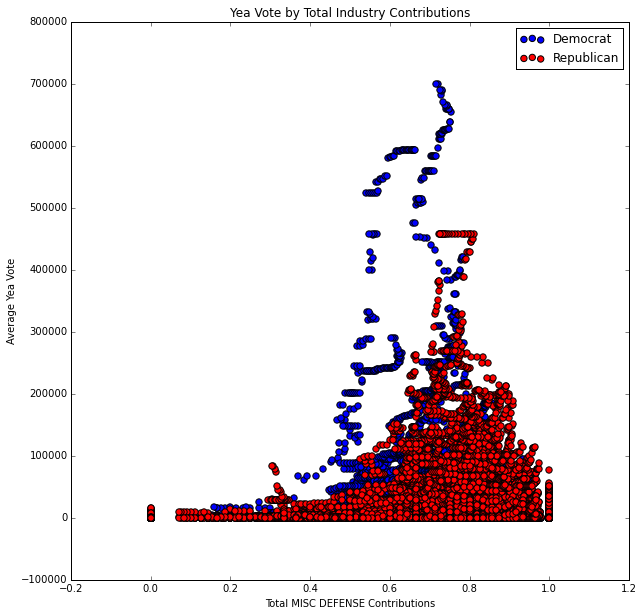

In [158]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)


ax.scatter(x=votes_df[votes_df['party'] == 'D']['prior_yea_percent'], 
           y=votes_df[votes_df['party'] == 'D']['MISC DEFENSE'],
          c='b', label='Democrat', s=40)
ax.scatter(x=votes_df[votes_df['party'] == 'R']['prior_yea_percent'], 
           y=votes_df[votes_df['party'] == 'R']['MISC DEFENSE'],
          c='r', label='Republican', s=40)
plt.legend(loc='upper right')
plt.title('Yea Vote by Total Industry Contributions')
plt.xlabel('Total MISC DEFENSE Contributions')
plt.ylabel('Average Yea Vote')
plt.show();

Modeling
==

## Test with campaign contributions as predictor varaibles:

## Model #1
Contributions as X features

**Find parameters to use for SVM**
Since grid search with SVM is computationally heave, I will get the parameters to use by subsetting the votes_df to 500 data points.

In [159]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 500
votes_df_modeling = votes_df.sample(500, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [160]:
X_scale

array([[-0.34976211,  1.05236272, -0.63473446, ..., -0.36506572,
        -0.76232852, -0.2074255 ],
       [-0.34976211, -0.22486951, -0.84418292, ..., -0.27844728,
        -0.61722465, -0.25003701],
       [-0.34963841, -0.22486951,  2.35097473, ...,  1.06305584,
         0.13176834, -0.25477163],
       ..., 
       [-0.34976211, -0.22486951, -0.60502697, ..., -0.21348345,
        -0.71506612, -0.25477163],
       [-0.34976211, -0.22486951, -0.55031391, ..., -0.3109292 ,
        -0.59649553, -0.25477163],
       [-0.27560404, -0.22486951,  0.45478224, ..., -0.13769231,
         0.89197164, -0.25477163]])

In [161]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,MISC DEFENSE,PUBLIC SECTOR UNIONS,WOMEN'S ISSUES
50315,0,500,9800,0,0,0,0,1000,2201,12465,0,0,2500
47103,0,0,0,0,0,0,0,0,0,2000,4000,17500,250


In [162]:
# This is too expensive to run for now, but my work can be found
# here: https://github.com/alexhubbard89/DAT-NYC-30_alex_hubbard/blob/master/final_project/Money%20in%20Politics%20-%20The%20relationship%20between%20contributions%20and%20congressional%20voting%20-%20findinds.ipynb

# time how long this takes to perform
# varible for starting the block of code
start = dt.datetime.now()

# variable for parameters to try
params = {'C': np.linspace(.001, 10, 10), 'kernel': ['poly', 'rbf', 'linear'],
         'degree': range(1,4), 'gamma': np.linspace(.001, 10, 10)}
clf = SVC()
grid = GridSearchCV(clf, params, cv=cv, n_jobs=-1)

# fir the data with multiple parameters
grid.fit(X_train, y_train)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

KeyboardInterrupt: 

In [163]:
grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

**Take best parameters and use in PCA-SVM model**

**Re-subset data, and set up test-train**

In [164]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(10000, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [165]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,MISC DEFENSE,PUBLIC SECTOR UNIONS,WOMEN'S ISSUES
50315,0,500,9800,0,0,0,0,1000,2201,12465,0,0,2500
47103,0,0,0,0,0,0,0,0,0,2000,4000,17500,250


In [166]:
n_components_input = X.columns.shape[0]
pca = PCA(n_components=n_components_input)
pca.fit(X_train)

tot = sum(pca.explained_variance_ratio_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print var_exp
print cum_var_exp

[31.644043284093552, 18.433948859057907, 9.2520999442015928, 7.8894281367486769, 6.6290828917502838, 6.2759031658317737, 5.2774461840533293, 4.9870858360217838, 2.7078516097157124, 2.5237688877321638, 1.843325104169254, 1.7019090474478169, 0.83410704917614376]
[  31.64404328   50.07799214   59.33009209   67.21952022   73.84860312
   80.12450628   85.40195247   90.3890383    93.09688991   95.6206588
   97.4639839    99.16589295  100.        ]


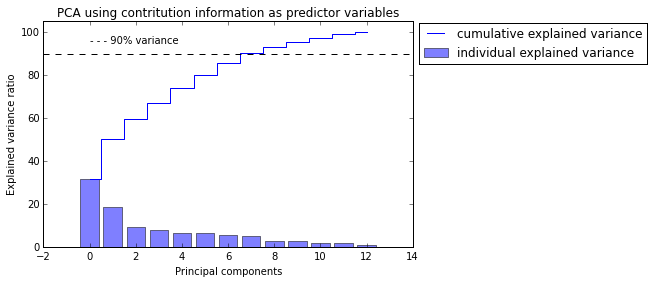

In [167]:
# plot variance
# add dotted line at 90%
plt.figure(figsize=(6, 4))

plt.bar(range(n_components_input), var_exp, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(n_components_input), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.ylim(0, 105)
plt.legend(bbox_to_anchor=(1.65, 1.02))
plt.axhline(y=90, ls='dashed', lw=1, color='black')
plt.annotate('- - - 90% variance', xy=(0, 95), xytext=(0, 95))
plt.title("PCA using contritution information as predictor variables")
plt.tight_layout()

In [168]:
## Run models
# first run PCA for dimension reduction
# then run SVM with reduced dimensions

start = dt.datetime.now()
# run pca

pca = PCA(n_components=.9, whiten=True)
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

# Run SVM

clf = SVC(C=0.001, degree=3, gamma=1.1119999999999999, kernel='poly')
clf.fit(X_t_train, y_train)
print 'pred label', clf.predict(X_t_test)
print "\nBelow are the results of using contritution information as predictor variables:"
print classification_report(clf.predict(X_t_test), y_test)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

pred label [1 1 1 ..., 1 1 1]

Below are the results of using contritution information as predictor variables:
             precision    recall  f1-score   support

         -1       0.00      0.50      0.01         4
          0       0.00      0.00      0.00         0
          1       1.00      0.70      0.83      1996

avg / total       1.00      0.70      0.82      2000

40 seconds


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [169]:
print 'yea baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==1)/pd.DataFrame(y_test).shape[0]*100)
print 'no baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==-1)/pd.DataFrame(y_test).shape[0]*100)
print 'not vote baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==0)/pd.DataFrame(y_test).shape[0]*100)

print '\nyea baseline (all data): {}%%'.format(sum(votes_df['class_variable']==1)/votes_df.shape[0]*100)
print 'no baseline (all data): {}%%'.format(sum(votes_df['class_variable']==-1)/votes_df.shape[0]*100)
print 'not vote baseline (all data): {}%%'.format(sum(votes_df['class_variable']==0)/votes_df.shape[0]*100)

yea baseline (test data): 70.3%%
no baseline (test data): 26.5%%
not vote baseline (test data): 3.2%%

yea baseline (all data): 70.8194732517%%
no baseline (all data): 26.4469925253%%
not vote baseline (all data): 2.73353422299%%


## Model #2
Historical voting patterns as X features

In [ ]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(100, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'ABORTION POLICY PRO-CHOICE', u'ACCOUNTANTS', u'BUSINESS SERVICES',
                               u'DEFENSE AEROSPACE', u'DEFENSE ELECTRONICS', u'DEMOCRATIC LIBERAL',
                               u'ENVIRONMENT', u'FOREIGN & DEFENSE POLICY', u'GENERAL CONTRACTORS',
                               u'LOBBYISTS', u'MISC DEFENSE', u'PUBLIC SECTOR UNIONS',
                               u"WOMEN'S ISSUES", u'bill_id', u'class_variable', u'date',
                               u'display_name', u'first_name', u'id', u'last_name', u'no',
                               u'not voting', u'opensecrets_id', u'state', u'subjects_top_terms', u'yea',
                               'total_votes_on_bill'],1), votes_df_modeling['class_variable']
X = pd.get_dummies(X).drop(['party_R'], 1)

# Scale data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [ ]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

In [ ]:
# This is too expensive to run for now, but my work can be found
# here: https://github.com/alexhubbard89/DAT-NYC-30_alex_hubbard/blob/master/final_project/Money%20in%20Politics%20-%20The%20relationship%20between%20contributions%20and%20congressional%20voting%20-%20findinds.ipynb

# time how long this takes to perform
# varible for starting the block of code
start = dt.datetime.now()

# variable for parameters to try
params = {'C': np.linspace(.001, 10, 10), 'kernel': ['poly', 'rbf', 'linear'],
         'degree': range(1,4), 'gamma': np.linspace(.001, 10, 10)}
clf = SVC()
grid = GridSearchCV(clf, params, cv=cv, n_jobs=-1)

# fir the data with multiple parameters
grid.fit(X_train, y_train)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

In [ ]:
grid.best_params_

**Take best parameters and use in PCA-SVM model**

**Re-subset data, and set up test-train**

In [170]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(10000, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'ABORTION POLICY PRO-CHOICE', u'ACCOUNTANTS', u'BUSINESS SERVICES',
                               u'DEFENSE AEROSPACE', u'DEFENSE ELECTRONICS', u'DEMOCRATIC LIBERAL',
                               u'ENVIRONMENT', u'FOREIGN & DEFENSE POLICY', u'GENERAL CONTRACTORS',
                               u'LOBBYISTS', u'MISC DEFENSE', u'PUBLIC SECTOR UNIONS',
                               u"WOMEN'S ISSUES", u'bill_id', u'class_variable', u'date',
                               u'display_name', u'first_name', u'id', u'last_name', u'no',
                               u'not voting', u'opensecrets_id', u'state', u'subjects_top_terms', u'yea',
                               'total_votes_on_bill'],1), votes_df_modeling['class_variable']
X = pd.get_dummies(X).drop(['party_R'], 1)

# Scale data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [171]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,party_D
50315,1,6,4,0.833333,5,0
47103,0,3,3,1.000000,3,1


In [172]:
n_components_input = X.columns.shape[0]
pca = PCA(n_components=n_components_input)
pca.fit(X_train)

tot = sum(pca.explained_variance_ratio_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print var_exp
print cum_var_exp

[53.318143376592964, 27.290458109179315, 13.951859832779018, 5.4213407127576021, 0.018197968691104769, 6.9102705364898901e-29]
[  53.31814338   80.60860149   94.56046132   99.98180203  100.          100.        ]


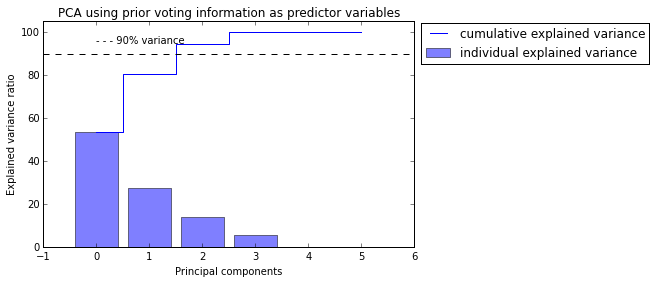

In [173]:
# plot variance
# add dotted line at 90%
plt.figure(figsize=(6, 4))

plt.bar(range(n_components_input), var_exp, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(n_components_input), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.ylim(0, 105)
plt.legend(bbox_to_anchor=(1.65, 1.02))
plt.axhline(y=90, ls='dashed', lw=1, color='black')
plt.annotate('- - - 90% variance', xy=(0, 95), xytext=(0, 95))
plt.title("PCA using prior voting information as predictor variables")
plt.tight_layout()

In [174]:
## Run models
# first run PCA for dimension reduction
# then run SVM with reduced dimensions

start = dt.datetime.now()
# run pca
print "PCA starting"

pca = PCA(n_components=.9, whiten=True)
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

# Run SVM
print "SVM starting"

clf = SVC(C=0.001, degree=3, gamma=3.3340000000000001, kernel='poly')
clf.fit(X_t_train, y_train)
print 'pred label', clf.predict(X_t_test)
print "\nBelow are the results of using prior voting information as predictor variables:"
print classification_report(clf.predict(X_t_test), y_test)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

PCA starting
SVM starting
pred label [1 1 1 ..., 1 1 1]

Below are the results of using prior voting information as predictor variables:
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       0.00      0.00      0.00         0
          1       1.00      0.70      0.83      2000

avg / total       1.00      0.70      0.83      2000

1 seconds


In [175]:
print 'yea baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==1)/pd.DataFrame(y_test).shape[0]*100)
print 'no baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==-1)/pd.DataFrame(y_test).shape[0]*100)
print 'not vote baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==0)/pd.DataFrame(y_test).shape[0]*100)

print '\nyea baseline (all data): {}%%'.format(sum(votes_df['class_variable']==1)/votes_df.shape[0]*100)
print 'no baseline (all data): {}%%'.format(sum(votes_df['class_variable']==-1)/votes_df.shape[0]*100)
print 'not vote baseline (all data): {}%%'.format(sum(votes_df['class_variable']==0)/votes_df.shape[0]*100)

yea baseline (test data): 70.3%%
no baseline (test data): 26.5%%
not vote baseline (test data): 3.2%%

yea baseline (all data): 70.8194732517%%
no baseline (all data): 26.4469925253%%
not vote baseline (all data): 2.73353422299%%
